# Classification Using Scikit-learn

In this homework you will learn how to build a basic supervised learning algorithm (classification) using the most popular Python machine learning library, scikit-learn. You will follow the 3 canonical steps for building a model:

1) Data preparation
2) Model fitting
3) Model evaluation & selection

We will use the World Happiness Report (WHR) data, bringing in some additional information that will enable us to formulate a classification problem to predict categorical labels on the dataset.

# Data Preparation

Execute the code cell below to import some modules and read in and preprocess the WHR data.  The last line in the code cell below returns the head of the basic WHR dataframe, to show you what is in that dataset.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
%matplotlib inline

dfraw = pd.read_excel('WHR2018Chapter2OnlineData.xlsx', sheet_name='Table2.1')


cols_to_include = ['country', 'year', 'Life Ladder', 
                   'Positive affect','Negative affect',
                   'Log GDP per capita', 'Social support',
                   'Healthy life expectancy at birth', 
                   'Freedom to make life choices', 
                   'Generosity', 'Perceptions of corruption']
renaming = {'Life Ladder': 'Happiness', 
            'Log GDP per capita': 'LogGDP', 
            'Social support': 'Support', 
            'Healthy life expectancy at birth': 'Life', 
            'Freedom to make life choices': 'Freedom', 
            'Perceptions of corruption': 'Corruption', 
            'Positive affect': 'Positive', 
            'Negative affect': 'Negative'}
df = dfraw[cols_to_include].rename(renaming, axis=1)
key_vars = ['Happiness', 'LogGDP', 'Support', 'Life', 'Freedom', 'Generosity', 'Corruption', 'Positive', 'Negative']
df.head()

,country,year,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.723590,0.517637,0.258195,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686
1,Afghanistan,2009,4.401778,0.583926,0.237092,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035
2,Afghanistan,2010,4.758381,0.618265,0.275324,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766
3,Afghanistan,2011,3.831719,0.611387,0.267175,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109
4,Afghanistan,2012,3.782938,0.710385,0.267919,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620


### Step 1.

First, we will augment the core WHR dataset to bring in some additional information that is included in a different worksheet.  Since this is mostly about data processing rather than machine learning, simply execute the next two code cells below.  But study each line of code and the associated comments, and then examine the head of the new dataframe named ```df2``` to understand what has been done.

In [14]:
# read in data from SupportingFactors worksheet into a new dataframe dfsupp
dfsupp = pd.read_excel('WHR2018Chapter2OnlineData.xlsx', sheet_name='SupportingFactors')

# extract out region information from SupportingFactors dataframe
regions = dfsupp[['country', 'Region indicator']].rename({'Region indicator': 'region'}, axis=1)

# examine head of regions dataframe -- each country has an associated world region
regions.head()

,country,region
0,Afghanistan,South Asia
1,Albania,Central and Eastern Europe
2,Algeria,Middle East and North Africa
3,Angola,Sub-Saharan Africa
4,Argentina,Latin America and Caribbean


In [30]:
# compute the mean values of all the WHR data for each country, averaging over all years in the dataset
dfmean = df.groupby('country').mean().drop('year', axis=1)

# merge the mean WHR data with the region information extracted previously
df2 = pd.merge(dfmean, regions, on='country').dropna()

# set the index of df2 to be the country name
df2.set_index('country', inplace=True)

# examine head of df2 dataframe -- mean WHR values for each country, along with associated regions
df2.head()

,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,region
country,,,,,,,,,,
Afghanistan,3.806614,0.580873,0.301283,7.419697,0.517146,50.838271,0.544895,0.118428,0.826794,South Asia
Albania,4.988791,0.642628,0.303256,9.247059,0.723204,68.027213,0.626155,-0.105019,0.859691,Central and Eastern Europe
Algeria,5.555004,0.616524,0.265460,9.501728,0.804633,64.984461,0.536398,-0.208236,0.661478,Middle East and North Africa
Angola,4.420299,0.613339,0.351173,8.713935,0.737973,51.729801,0.455957,-0.077940,0.867018,Sub-Saharan Africa
Argentina,6.406131,0.840998,0.273187,9.826051,0.906080,66.764205,0.753122,-0.154544,0.844038,Latin America and Caribbean


### Step 2.

This new dataframe ```df2``` is what we want to use for our machine learning task.  For each country in the dataset, we have a set of numerical values ('Happiness', 'Positive', 'Negative', etc., which are all listed in the variable ```key_vars```) and a categorical value ('region').  We would like to know if the raw numerical data are  predictive of the region.  In other words, if someone gave you a set of numerical data on Happiness, etc. for an unknown country, would you be able to predict what region of the world it might be located in?  This is an example of classification, where we will train a model based on the numerical data and the associated labels (regions).

In order to proceed, we first want to extract and process some data from our ```df2``` dataframe.  We need to separate the data into two parts:
* the region data that we want to be able to predict (we'll call it ```y```)
* the WHR numerical data that we want to use as input to our prediction (we'll call it ```x```)

Again, our goal is to build a classifier that we will train on a subset of the WHR numerical data (x) and the region data (y), so that we can predict regions from data for countries that we have not trained our model on.

In the code cell below:
* Extract the subset of ```df2``` associated with the columns in ```key_vars``` and assign it to the variable ```x```.
* Extract the subset of ```df2``` associated with the region column, and assign it to the variable ```y```.
* Print the shape of both `x` and `y`.

## Graded Cell

This cell is worth 5% of the grade for this assignment.

In [16]:
# assigning the features to the x and y vars 
x = df2[key_vars]
y = df2['region']

# printing the shapes shapes of x and y
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (152, 9)
Shape of y: (152,)


### Step 3.

You should see that the shape of ```x``` is (152, 9) and the shape of ```y``` is (152,).  There are 152 samples (countries), and 9 features (each of the key_vars) that we are using to make predictions.

Note that the numerical data columns in ```x``` represent different quantities and have different scales. A key step in machine learning is _standardization_: the transformation of features to be on the same scale (with a mean of 0 and a standard deviation of 1). Standardization can substantially increase model accuracy, performance and interpretability.

`sklearn` provides various utilities to perform standardization.  We will use one here called ```StandardScaler```, which will transform a data set so that each resulting column has zero mean and unit standard deviation.

Carrying out this scaling is a little complicated if we want to maintain the basic structure of our dataframe, so we have provided the relevant code in the next code cell below.  (The code examples describing StandardScaler in the [sklearn documentation](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler) typically just extract out the numerical values in numpy arrays. For this exercise, we'd like to keep the labels together in a dataframe.)

Please perform the following steps in the below graded cell:
* Import the `StandardScaler` object
* Create and fit a `StandardScaler` object to our dataframe ```x```
* Create a new dataframe ```x_scaled``` that contains the scaled (transformed) data, using the column and index labels from our unscaled dataframe ```x```
* Print out the mean and standard deviation of each column of ```x_scaled```
* Peek at the head of the new dataframe ```x_scaled```

In examining the output, check that the means of each column have been scaled to nearly zero (to within a very small tolerance) and the standard deviations have been scaled to one. Some of the very small numbers might be printed out in scientific notation, where a number like ```1.928282e-16``` means ```1.928282 * 10**(-16)```.

## Graded Cell

This cell is worth 20% of the grade for this assignment.

In [17]:
from sklearn.preprocessing import StandardScaler

# Create and fit the StandardScaler
scaler = StandardScaler()
scaler.fit(x)

# Transform the data and create a new DataFrame
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns, index=x.index)

# Print mean and standard deviation for each column
print("Means of each column in x_scaled:")
print(x_scaled.mean())
print("\nStandard deviations of each column in x_scaled:")
print(x_scaled.std())

# Peek at the head of x_scaled
print("\nHead of x_scaled:")
print(x_scaled.head())

Means of each column in x_scaled:
Happiness     1.782200e-16
LogGDP        6.135443e-17
Support      -2.337312e-16
Life         -5.843279e-17
Freedom       6.748987e-16
Generosity    1.168656e-17
Corruption    9.349247e-17
Positive      1.811417e-16
Negative      2.337312e-16
dtype: float64

Standard deviations of each column in x_scaled:
Happiness     1.003306
LogGDP        1.003306
Support       1.003306
Life          1.003306
Freedom       1.003306
Generosity    1.003306
Corruption    1.003306
Positive      1.003306
Negative      1.003306
dtype: float64

Head of x_scaled:
             Happiness    LogGDP   Support      Life   Freedom  Generosity  \
country                                                                      
Afghanistan  -1.443128 -1.438896 -2.425953 -1.333584 -1.397623    0.735439   
Albania      -0.360792  0.054466 -0.681799  0.776161 -0.776670   -0.719736   
Algeria       0.157600  0.262588  0.007447  0.402698 -1.462554   -1.391919   
Angola       -0.881273 -0.38

# Model Fitting

### Step 4.

Now that the data has been preprocessed, we can begin with our classification analysis.  Let's start by importing some additional tools from `sklearn`.  Execute the code cell below to import:
* the ```svm``` and ```tree``` submodules
* the ```train_test_split``` function
* the ```accuracy_score``` function

We'll discuss in more detail below what each of these does.

In [19]:
from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

### Step 5.

One of the convenience functions that we imported above is called ```train_test_split```.  As its name suggests, this function splits a dataset into separate training and testing sets.  The [online documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn-model-selection-train-test-split) indicates that it splits a dataset randomly, such that approximately 25% of the data winds up in the test set and the remaining 75% in the training set.  Note that the documentation is a bit confusing, since the function can take a variable number of arrays as inputs. In our case, we want to split up 2 arrays (```x_scaled``` and ```y```) into coordinated test and train sets, so that the function will return a total of 4 subarrays (```x_train, x_test, y_train, y_test```).

Because ```train_test_split``` generates random splits of the input data, each time we call the function we will get a different split.  For the purposes of code development, it's useful to be able to get reproducible random numbers or random splits, as it makes debugging and model improvements much easer. This can then be relaxed once one wishes to generate statistics over many random runs.     With ```train_test_split```, this can be accomplished by using the ```random_state``` option; if specified with that state as an integer, then the same random split will be generated each time the function is called (until one changes the value of the integer).  This is known as providing a seed to the pseudo-random number generator that is used by ```train_test_split```.

You may enter and execute a call to ```train_test_split``` that takes ```x_scaled``` and ```y``` as inputs, along with the optional parameter ```random_state=0```, and returns the 4 data subsets mentioned above, to be named as ```x_train```, ```x_test```, ```y_train```, ```y_test```.  The online documentation provides an example of what such a function call looks like. After the function call, print the shapes of each of the four arrays that are returned.

At first pass, it makes sense to simply apply ```train_test_split()``` directly to ```x_scaled``` and ```y```; however, there is a subtle downside. Performing standardization prior to ```train_test_split()``` potentially leads to 'information leakage' whereby information about the testing dataset (its underlying distribution) is learned during the training phase. This is because the testing data distribution is used to scale the training dataset. 

In the code cell below, please perform ```train_test_split()``` first before applying ```StandardScaler().fit()``` *only* to the training dataset. Use that fit to transform the training dataset and the testing dataset separately. Ultimately, you should end up with the variables ```x_train_scale```, ```x_test_scale```, ```y_train``` and ```y_test``.

## Graded Cell

This cell is worth 5% of the grade for this assignment.

In [20]:
# train and test split 
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# creating and fiting the standard scaler to the training split
scaler = StandardScaler()
scaler.fit(x_train)

# applying the transforming to both the train and test splits
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# shape printing
print("Shape of x_train_scaled:", x_train_scaled.shape)
print("Shape of x_test_scaled:", x_test_scaled.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train_scaled: (114, 9)
Shape of x_test_scaled: (38, 9)
Shape of y_train: (114,)
Shape of y_test: (38,)


### Step 6.

Having split our datasets, we want to first train a classifier on our training data so that we can apply it to the testing data.  One way of assessing the performance of a classifier is to compute its accuracy on the test data. That is, what fraction of the test data are correctly predicted by the classifier?  Fortunately, `sklearn` provides a built-in function named ```accuracy_score``` that carries out this computation. We imported it above, and you can read more about it in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy_score#sklearn.metrics.accuracy_score).

We also imported above the ```svm``` and ```tree``` submodules from sklearn.  These provide support for Support Vector Machine (svm) and Decision Tree (tree) machine learning algorithms.  For more information, review the [Support Vector Machines (SVMs) documentation](https://scikit-learn.org/stable/modules/svm.html) and the [Decision Trees documentation](https://scikit-learn.org/stable/modules/tree.html).  Under the hood, these are very different types of algorithms.  Decision Trees try to formulate a series of yes/no questions based on the data that can distinguish the categories from one another.  SVMs, on the other hand, use techniques from geometry to find cuts through the data space to separate different categories from one another.  Understanding how these methods work in detail is beyond the scope of this exercise, but fortunately (despite the very different data structures and algorithms used internally) `sklearn` provides a uniform interface that lets us easily build these different sorts of classifiers and compare their performance.

We will first consider SVMs, and then revisit the problem with Decision Trees.

In the code cell below:
* create a new ```svm.SVC()``` object and assign it to the variable ```clf1``` &mdash;  a call to ```svm.SVC()``` creates a Support Vector Classifier from the svm submodule, similar to what we did in the earlier exercise on hand-written digits
* call the ```fit``` method on ```clf1``` with the `x_train_scale` and `y_train` training data (i.e., training the model to associate ```x_train_scale``` with ```y_train```)
* call the ```predict``` method on ```clf1``` on the `x_test_scale` testing data and assign the result to the variable ```predictions1```, in order to make predictions for those inputs
* call the ```accuracy_score``` function on the `y` testing data and the test predictions you generated and assign the result to the variable ```score1```
* print the value of ```score1```

The accuracy score is a fraction between 0 and 1 indicating the fraction of predictions that match the true value in the test set.

## Graded Cell

This cell is worth 20% of the grade for this assignment.

In [21]:
# making the SVM classifier
clf1 = svm.SVC()

# training the classifier 
clf1.fit(x_train_scaled, y_train)

SVC()

In [22]:
# Making predictions on the test data
predictions1 = clf1.predict(x_test_scaled)

# Calculating the accuracy score
score1 = accuracy_score(y_test, predictions1)

# Printing the accuracy score
print("Accuracy of SVM classifier:", score1)

Accuracy of SVM classifier: 0.7105263157894737


### Step 7.

The accuracy score reported should be around 71% (0.71).  This means that approximately 29% of the countries in the test set had their regions mispredicted.  While that doesn't sound great, it could be that the WHR numerical data are not always completely predictive of region. One could imagine some countries that are "outliers" in a particular region, and more closely resemble other regions based on the WHR indicators.

In the below code cell, please loop over all the predicted and true values in the test set, and prints out the country name and predicted region when the prediction is incorrect.  An output line like: ```Sri Lanka : South Asia -> Sub-Saharan Africa``` means that Sri Lanka is actually part of the South Asia region but was predicted to be part of Sub-Saharan Africa.

## Graded Cell

This cell is worth 10% of the grade for this assignment.

In [32]:
# looping over the test set
for idx in x_test.index:
    actual_region = y_test.loc[idx]
    predicted_region = predictions1[x_test.index.get_loc(idx)]
    
    # getting the country name 
    country_name = x_test.loc[idx, 'country'] if 'country' in x_test.columns else idx

    # checking and printing 
    if actual_region != predicted_region:
        print(f"{country_name} : {actual_region} -> {predicted_region}")

Israel : Middle East and North Africa -> Western Europe
Sri Lanka : South Asia -> Sub-Saharan Africa
Tajikistan : Commonwealth of Independent States -> Sub-Saharan Africa
Yemen : Middle East and North Africa -> Sub-Saharan Africa
Hong Kong S.A.R. of China : East Asia -> Western Europe
Philippines : Southeast Asia -> Latin America and Caribbean
Italy : Western Europe -> Central and Eastern Europe
Slovenia : Central and Eastern Europe -> Western Europe
Gabon : Sub-Saharan Africa -> Middle East and North Africa
Azerbaijan : Commonwealth of Independent States -> Middle East and North Africa
Malaysia : Southeast Asia -> Latin America and Caribbean


# Model evaluation & selection

### Step 8.

It is often not obvious what specific algorithm will work best for a particular dataset, so it is good to be able to conduct numerical experiments to see how different methods perform (even if we might not fully understand *why* one method might work better than another).  Because `sklearn` provides a consistent interface to very different types of underlying algorithms, it is easy to build additional classifiers to carry out these kinds of comparisons.  Here, we will build a second classifier based on Decision Trees as supported by the ```tree``` module.  Decision Tree algorithms have an element of randomness to them, so a Decision Tree can also be constructed with a specified ```random_state```  such as an integer that seeds the random number generator.  Most of what we will do here is very similar to the code you wrote a few cells up when you built a SVC classifier.

In the code cell below:

* Create a new ```tree.DecisionTreeClassifier()``` object with the optional argument ```random_state=0```, and assign it to the variable ```clf2``` (`clf2` stands for "classifier number 2", so that we can compare with ```clf1``` above).
* Call the ```fit``` method on ```clf2``` with the `x_train_scale` and `y_train` training data (i.e., training the model to associate ```x_train_scale``` with ```y_train```).
* Call the ```predict``` method on ```clf2``` on the `x_test_scale` testing data and assign the result to the variable ```predictions2```, in order to make predictions for those inputs.
* Call the ```accuracy_score``` function on the `y_test` testing data and the test predictions you generated and assign the result to the variable ```score2```.
* Print the value of ```score2```.

## Graded Cell

This cell is worth 10% of the grade for this assignment.

In [34]:
# creating the decision tree classifier
clf2 = tree.DecisionTreeClassifier(random_state=0)

# training the classifier
clf2.fit(x_train_scaled, y_train)

# predicitions on the test 
predictions2 = clf2.predict(x_test_scaled)

# calculating the accuracy score
score2 = accuracy_score(y_test, predictions2)

# accuracy score
print("Accuracy of Decision Tree classifier:", score2)

Accuracy of Decision Tree classifier: 0.7631578947368421


### Step 9.

We ran two classifiers &mdash; ```clf1``` (SVM) and ```clf2``` (Decision Tree) &mdash; on a particular random `train_test_split` of the full dataset.  We can't really reach any conclusions about the relative performance of the two methods just by considering one split.  Given that ```train_test_split``` can produce different random splits, let's write a little code to compare the two classifiers for different splits.

In the code cell below, write some code to do the following:
* Write a Python `for` loop so that you can run through the loop 20 times
* Within each pass through the loop, do the following:
    * Call `test_train_split` on ```x``` and ```y``` to get new random instances of `x_train`, `x_test`, `y_train`, `y_test` -- in this case, you don't want to pass in a value for ```random_state``` since you want to get different random splits each time
    * Fit StandardScaler to `x_train`, and use it to transform both `x_train` and `x_test` into `x_train_scaled` and `x_train_test`
    * Fit each of the classifiers `clf1` and `clf2` to `x_train_scaled` and `y_train`
    * Run predictions on each of the classifiers `clf1` and `clf2` on the `x_test_scaled` and `y_test` testing data
    * Compute the accuracy_score of each of the two classifiers on the test data and the test predictions you generated 
    * Print the score of each classifier, as well as their difference (hint: ```print(score1, score2, score1-score2)``` to get just one line of output per iteration of the loop)
    
Execute the code you have written.  You should see it run through the loop 20 times, for different random data splits.  While the overall performance varies from run to run, you should probably see that the SVC classifier (```clf1```) generally performs a little bit better than the DecisionTree classifier (```clf2```).


## Graded Cell

This cell is worth 10% of the grade for this assignment. 

In [35]:
# getting the two classifiers
clf1 = svm.SVC()
clf2 = tree.DecisionTreeClassifier()

# for loop running random splits 
for i in range(20):
    # splitting
    x_train, x_test, y_train, y_test = train_test_split(x, y)

    # scaling
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # fitting
    clf1.fit(x_train_scaled, y_train)
    clf2.fit(x_train_scaled, y_train)

    # predicitions
    predictions1 = clf1.predict(x_test_scaled)
    predictions2 = clf2.predict(x_test_scaled)

    # getting accuracy scores
    score1 = accuracy_score(y_test, predictions1)
    score2 = accuracy_score(y_test, predictions2)

    # prinintg scores 
    print(score1, score2, score1 - score2)

0.7105263157894737 0.5789473684210527 0.13157894736842102
0.6578947368421053 0.6052631578947368 0.052631578947368474
0.631578947368421 0.6052631578947368 0.02631578947368418
0.5526315789473685 0.5 0.052631578947368474
0.7105263157894737 0.5526315789473685 0.1578947368421052
0.6578947368421053 0.5 0.1578947368421053
0.7105263157894737 0.5526315789473685 0.1578947368421052
0.7368421052631579 0.6842105263157895 0.05263157894736836
0.7631578947368421 0.7368421052631579 0.026315789473684292
0.5526315789473685 0.5526315789473685 0.0
0.7894736842105263 0.7631578947368421 0.02631578947368418
0.5526315789473685 0.5789473684210527 -0.02631578947368418
0.6842105263157895 0.7631578947368421 -0.07894736842105265
0.631578947368421 0.5 0.13157894736842102
0.7105263157894737 0.5789473684210527 0.13157894736842102
0.6842105263157895 0.6052631578947368 0.07894736842105265
0.7105263157894737 0.6578947368421053 0.05263157894736836
0.7631578947368421 0.6578947368421053 0.10526315789473684
0.815789473684210

### Step 10.

In the last code cell, you printed out the scores of the two classifiers for a small number of random splits, and examined the numerical output.  Perhaps you'd rather generate a visual summary of the relative performance of the two classifiers, for a larger number of runs.

In the code cell below, copy and paste the code you wrote above and modify it to do the following:

* prior to entering the `for` loop, initialize two empty lists named ```all_scores1``` and ```all_scores2``` that will be used to collect the scores of each classifier each time through the loop
* run through the loop 1000 times instead of 20 as before
* append the scores (```score1``` and ```score2```) to each of the lists used to contain all the scores
* remove the print statement so that you don't get 1000 annoying print statements when you run the code
* once the loop is finished, use the ```plt.hist``` function to plot histograms for ```all_scores1``` and ```all_scores2``` together in the same plot
    * you can accomplish this by making two successive calls to the histogram function within the same code cell
    * you might want to add options to change the number of bins for the histograms
    * you should change the alpha value (opacity) of the histogram plots so that you can see both distributions, since at full opacity, the second one plotted will obscure the first one
    * you should use the ``label`` option to label the datasets
* After making your two calls to ```plt.hist```, you should call ``plt.legend`` to produce a legend on the plot that will identify the two datasets based on the label options that you added to your ```plt.hist``` calls

## Graded Cell

This cell is worth 20% of the grade for this assignment.


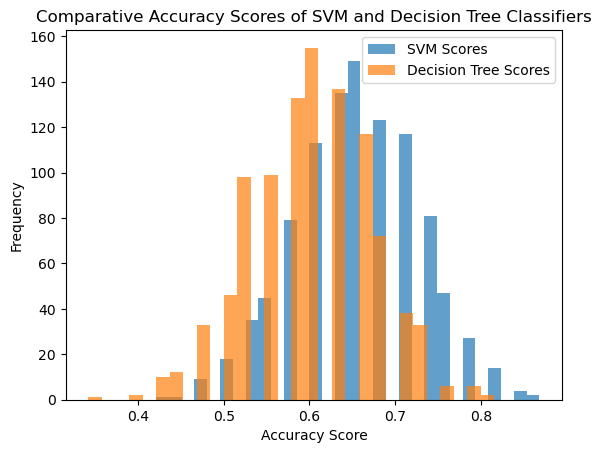

In [36]:
import matplotlib.pyplot as plt

# initializing the classifiers
clf1 = svm.SVC()
clf2 = tree.DecisionTreeClassifier()

# lists to collect scores
all_scores1 = []
all_scores2 = []

# for loop to run through 1000 random splits
for _ in range(1000):
    # splitting the sets 
    x_train, x_test, y_train, y_test = train_test_split(x, y)

    # scaling the data
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # fitting the classifiers
    clf1.fit(x_train_scaled, y_train)
    clf2.fit(x_train_scaled, y_train)

    # predictions
    predictions1 = clf1.predict(x_test_scaled)
    predictions2 = clf2.predict(x_test_scaled)

    # collecting the scores
    score1 = accuracy_score(y_test, predictions1)
    score2 = accuracy_score(y_test, predictions2)
    all_scores1.append(score1)
    all_scores2.append(score2)

# making histograms of the scores
plt.hist(all_scores1, bins=30, alpha=0.7, label='SVM Scores')
plt.hist(all_scores2, bins=30, alpha=0.7, label='Decision Tree Scores')
plt.legend()
plt.title("Comparative Accuracy Scores of SVM and Decision Tree Classifiers")
plt.xlabel("Accuracy Score")
plt.ylabel("Frequency")
plt.show()

### Just scratching the surface...

This is just the start of what you can do with scikit-learn.  It is clear from the documentation that there are many different methods and algorithms for classification that are supported by the package, as well as different ways of optimizing and assessing the performance of different algorithms.  If you are motivated to explore further, feel free to continue below by opening more code cells and using the scikit-learn documentation to guide some further exploration.

# What to Submit?

Please run your Jupyter Notebook first to generate outputs for each code cell and then export the report as a HTML file by clicking the following links (File -> Download as -> HTML (.html)). Please zip both the Jupyter Notebook and the HTML file and submit your ZIP file.